### Initialise libraries and function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from scipy import interpolate
from scipy.interpolate import griddata
import time
import random

path = os.getcwd()
path_data = "/home/ucecabj/Desktop/pyMFI_git/DATA_examples/FES4_1D"
print("The path to this notebook is:", path, "\nThe current location is the data folder:", path_data)

#import MFI
os.chdir("/home/ucecabj/Desktop/pyMFI_git/pyMFI/")
import MFI1D
import run_plumed as plumed

#change locaiton to path_data
os.chdir(path_data)

The path to this notebook is: /home/ucecabj/Desktop/pyMFI_git/Notebooks 
The current location is the data folder: /home/ucecabj/Desktop/pyMFI_git/DATA_examples/FES4_1D


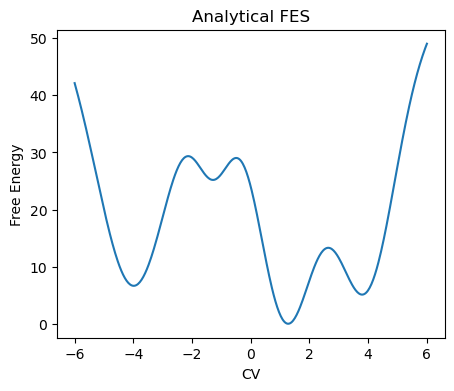

In [2]:
min_grid = -6
max_grid = 6
nbins = 401
grid = np.linspace(min_grid, max_grid, nbins)
y = - 45*np.exp(-0.5 * (((grid + 4.0) ** 2) / 1.5)) - 20*np.exp(-0.5 * (((grid + 1.26) ** 2) / 0.4)) - 50*np.exp(-0.5 * (((grid - 1.2) ** 2) / 1.0)) - 45*np.exp(-0.5 * (((grid - 3.9) ** 2) / 1.0)) + np.exp(-grid-5) + np.exp(grid-5)
y_string = "-45*exp(-0.5/1.5*(x+4.0)^2)-20*exp(-0.5/0.4*(x+1.26)^2)-50*exp(-0.5*(x-1.2)^2)-45*exp(-0.5*(x-3.9)^2)+exp(-x-5)^2+exp(x-5)"
y = y - min(y)

plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.title("Analytical FES"); plt.xlabel("CV"); plt.ylabel("Free Energy"); plt.show()

#Define constants 
bw = 0.05; bw2 = bw**2     
kT = 2.49 
n_steps = 100_000    
master = []    

### 1st simulation
Run a normal MetaD simulation and analyse it with MFI

In [3]:
master = []

#Run simuation
# plumed.run_langevin1D(n_steps, analytical_function = y_string, initial_position=-4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400)
# try: os.system("rm bck.*")
# except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS1")
position = MFI1D.load_position(position_name="position1")

#Run MFI algorithm to find force terms
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200)
grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results

#save results to master
master.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
        
#Patch master
[X, PD_patch, F_patch, FES, AD, AAD, OFE, AOFE] = MFI1D.patch_FES_AD_ofe(master, grid, y, nbins)

FES1, OFE1, AD1, PD1 = FES, OFE, AD, PD_patch

Ftot_ext = Ftot

100.0 %   OFE = 12.5785


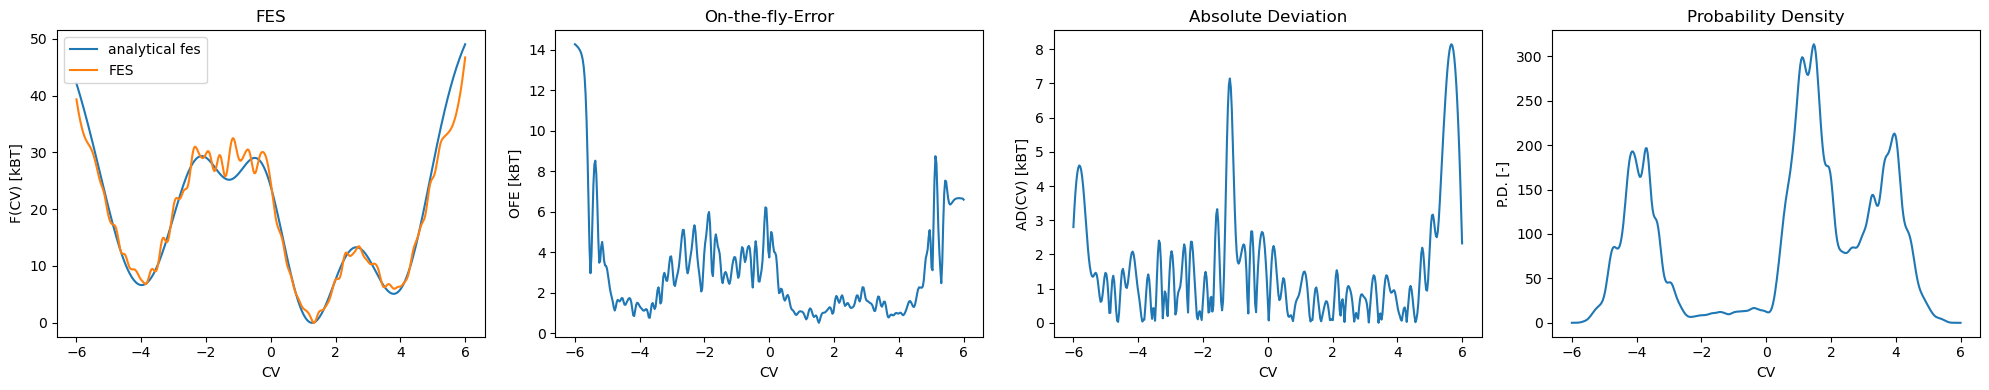

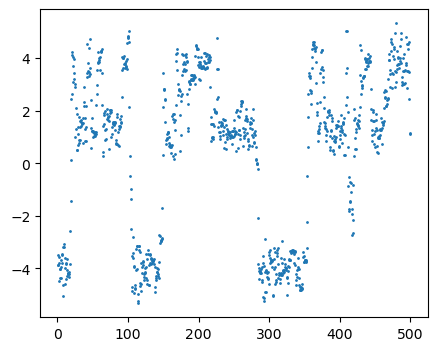

In [4]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

plt.subplot(1,4,2)
plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

plt.subplot(1,4,3)
plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

plt.subplot(1,4,4)
plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

plt.tight_layout(); plt.show()

HILLS=MFI1D.load_HILLS(hills_name="HILLS1")
plt.figure(figsize=(5,4)); plt.scatter(HILLS[:,0], HILLS[:,1], s=1); plt.show()

### Save FES as bias for next simulation

Save the nagetive of the FES to be used as an external bias for the next simulation. 

The first column should be the grid, the second column the energy, and the third column the force (derivative of enery).

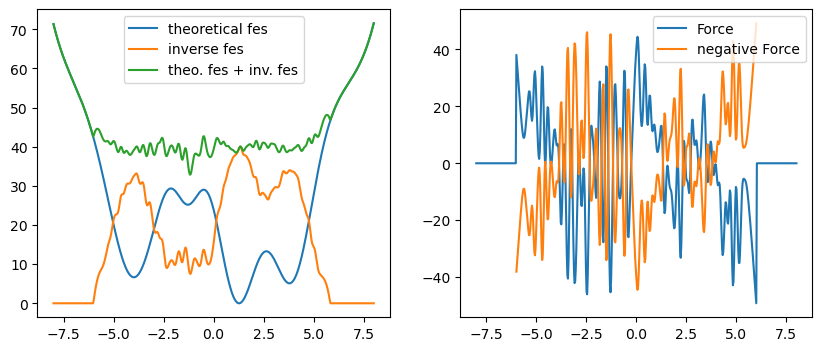

In [5]:
# Fin the external bias
[grid_plumed, FES_plumed, Ftot_plumed] = plumed.make_external_bias_1D(grid, FES, Ftot, grid_min_plumed=-8, grid_max_plumed=8, FES_cutoff=40)

#plot results
y_plumed = - 45*np.exp(-0.5 * (((grid_plumed + 4.0) ** 2) / 1.5)) - 20*np.exp(-0.5 * (((grid_plumed + 1.26) ** 2) / 0.4)) - 50*np.exp(-0.5 * (((grid_plumed - 1.2) ** 2) / 1.0)) - 45*np.exp(-0.5 * (((grid_plumed - 3.9) ** 2) / 1.0)) + np.exp(-grid_plumed-5) + np.exp(grid_plumed-5)
y_plumed = y_plumed - min(y_plumed)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(grid_plumed, y_plumed, label="theoretical fes")
plt.plot(grid_plumed, FES_plumed, label="inverse fes")
plt.plot(grid_plumed, FES_plumed + y_plumed, label="theo. fes + inv. fes")
plt.legend()

plt.subplot(1,2,2)
plt.plot(grid_plumed, Ftot_plumed, label="Force")
plt.plot(grid, Ftot, label="negative Force")
plt.legend(); plt.show()

### Run 2nd simulation with external bias

In [6]:
#Run metaD simulation with external bias (specify: external_bias_file="external_bias.dat")
plumed.run_langevin1D(n_steps, analytical_function = y_string, initial_position=4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400, external_bias_file="external_bias.dat")
try: os.system("rm bck.*")
except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")
position = MFI1D.load_position(position_name="position")

#Run MFI algorithm
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200, F_static=-Ftot_ext)


grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results


#save results to master
master.append([Ftot_den, Ftot_den2, Ftot, ofv_num])
        
#Patch master
[X, PD_patch, F_patch, FES, AD, AAD, OFE, AOFE] = MFI1D.patch_FES_AD_ofe(master, grid, y, nbins)

FES2, OFE2, AD2, PD2 = FES, OFE, AD, PD_patch

100.0 %   OFE = 14.0301


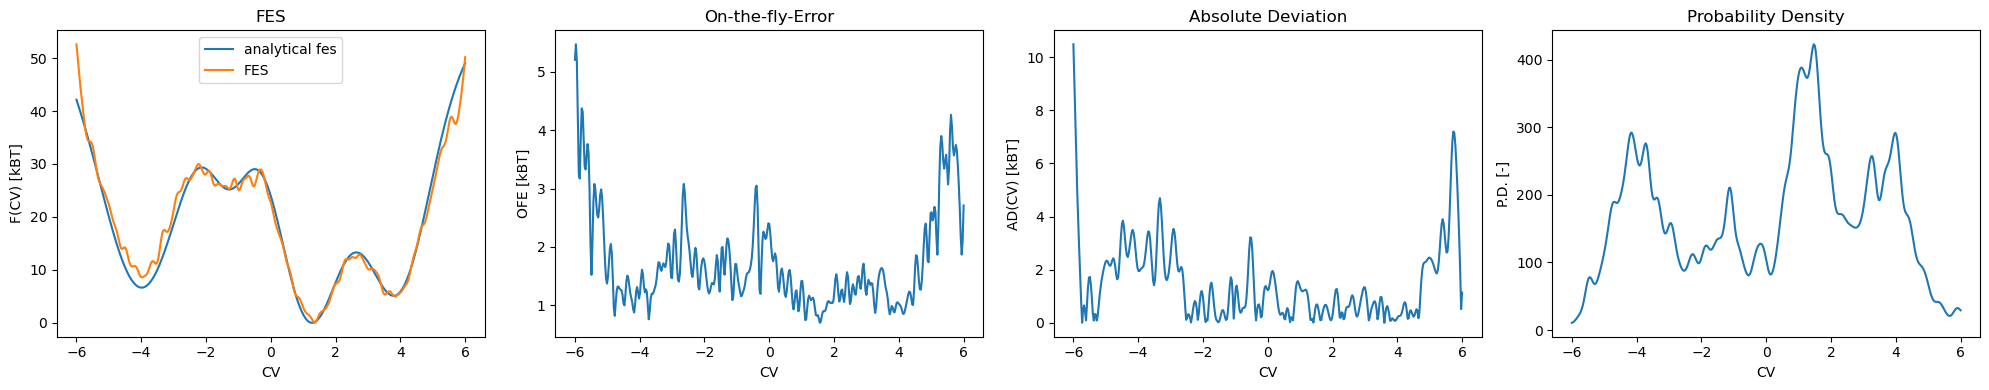

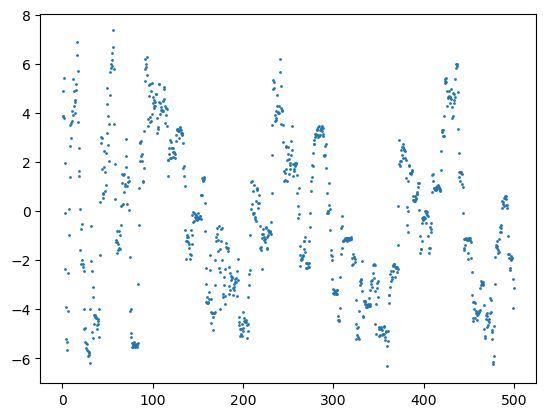

In [8]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

plt.subplot(1,4,2)
plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

plt.subplot(1,4,3)
plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

plt.subplot(1,4,4)
plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

plt.tight_layout(); plt.show()

HILLS=MFI1D.load_HILLS(hills_name="HILLS")
plt.scatter(HILLS[:,0], HILLS[:,1], s=1); plt.show();


### 3rd: one long simulation

Instead of running the two simulations from above with n_steps (100,000) steps each, one longer simulation is done using twice the steps. 


100.0 %   OFE = 12.4579


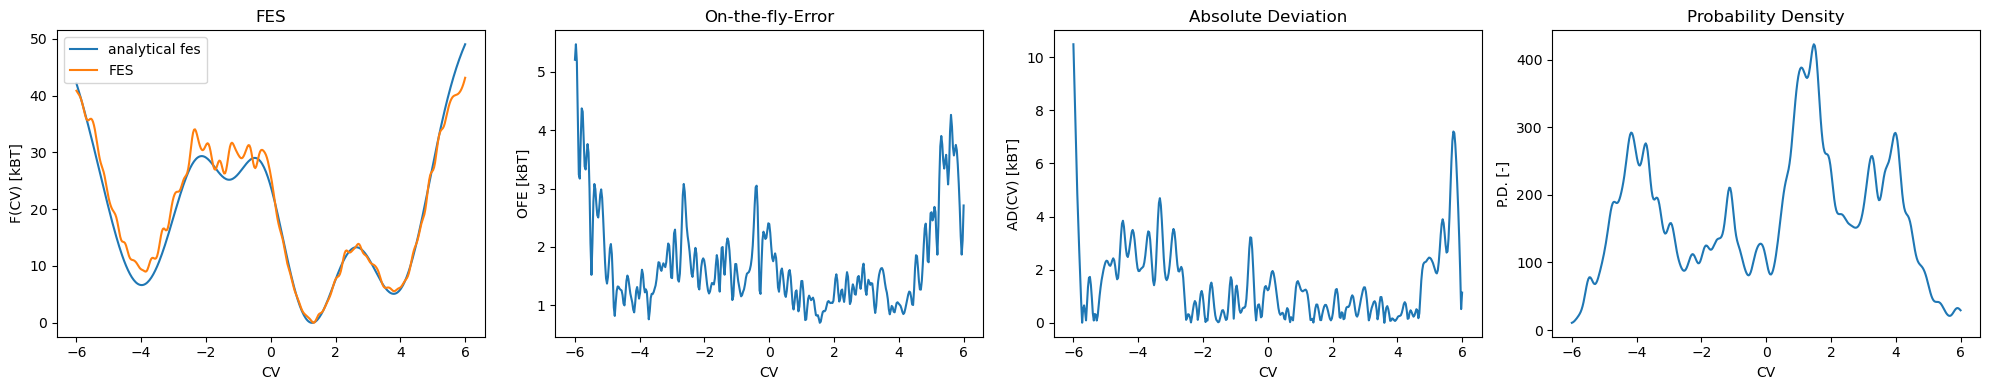

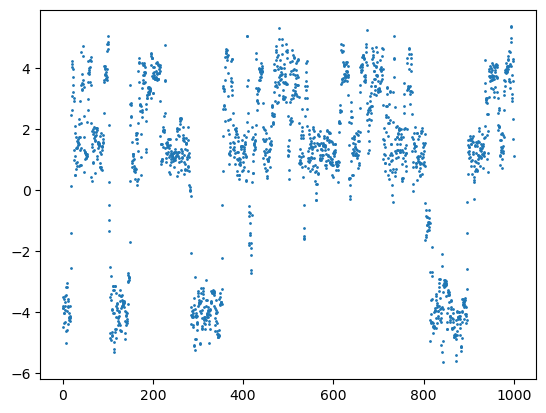

In [8]:
# #Run simuation
# plumed.run_langevin1D(int(n_steps*2), analytical_function = y_string, initial_position=-4.0,  gaus_width=0.1, gaus_height=5, biasfactor=10, grid_min=-8.0, grid_max=8.0, grid_bin=400)
# try: os.system("rm bck.*")
# except: pass

#Load HILLS and position file
HILLS=MFI1D.load_HILLS(hills_name="HILLS2")
position = MFI1D.load_position(position_name="position2")

#Run MFI algorithm to find force terms
results = MFI1D.MFI_1D( HILLS=HILLS, position=position, bw=0.1, min_grid=min_grid, max_grid=max_grid, nbins=nbins, log_pace=1, error_pace=200)
grid, Ftot_den, Ftot_den2, Ftot, ofv_num, FES, ofv, ofe, cutoff, error_history_collection, volume_history, intermediate_fes_collection, intermediate_cutoff_collection, intermediate_time_collection = results

FES3, OFE3, AD3, PD3 = FES, ofe, abs(FES-y), Ftot_den

for _ in [1]:
    plt.figure(figsize=(20,4))
    plt.subplot(1,4,1)
    plt.plot(grid, y, label="analytical fes"); plt.plot(grid, FES, label="FES"); plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

    plt.subplot(1,4,2)
    plt.plot(grid, OFE); plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]")

    plt.subplot(1,4,3)
    plt.plot(grid, AD); plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]")

    plt.subplot(1,4,4)
    plt.plot(grid, PD_patch); plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]")

    plt.tight_layout(); plt.show()

    HILLS=MFI1D.load_HILLS(hills_name="HILLS2")
    plt.scatter(HILLS[:,0], HILLS[:,1], s=1); plt.show();

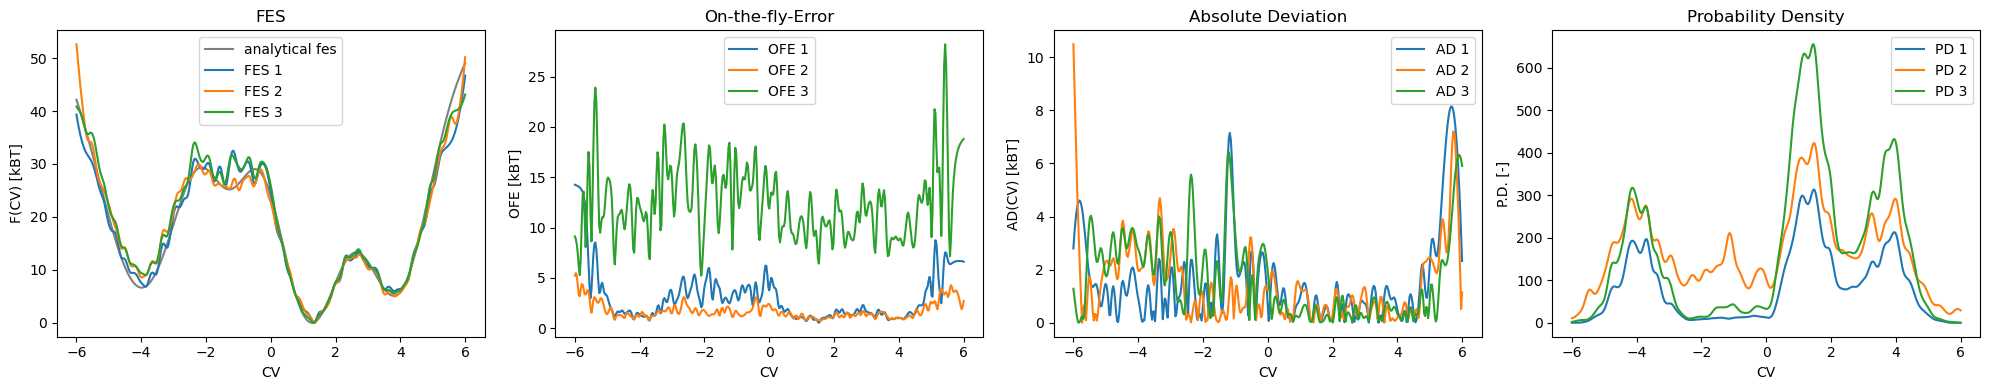

In [11]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.plot(grid, y, label="analytical fes", c="grey"); 
plt.plot(grid, FES1, label="FES 1"); 
plt.plot(grid, FES2, label="FES 2"); 
plt.plot(grid, FES3, label="FES 3"); 
plt.title("FES"); plt.xlabel("CV"); plt.ylabel("F(CV) [kBT]"); plt.legend()

plt.subplot(1,4,2)
plt.plot(grid, OFE1, label="OFE 1"); 
plt.plot(grid, OFE2, label="OFE 2"); 
plt.plot(grid, OFE3, label="OFE 3"); 
plt.title("On-the-fly-Error"); plt.xlabel("CV"); plt.ylabel("OFE [kBT]"); plt.legend()

plt.subplot(1,4,3)
plt.plot(grid, AD1, label="AD 1"); 
plt.plot(grid, AD2, label="AD 2"); 
plt.plot(grid, AD3, label="AD 3"); 
plt.title("Absolute Deviation"); plt.xlabel("CV"); plt.ylabel("AD(CV) [kBT]"); plt.legend()

plt.subplot(1,4,4)
plt.plot(grid, PD1, label="PD 1"); 
plt.plot(grid, PD2, label="PD 2"); 
plt.plot(grid, PD3, label="PD 3"); 
plt.title("Probability Density"); plt.xlabel("CV"); plt.ylabel("P.D. [-]"); plt.legend()

plt.tight_layout(); plt.show()